In [5]:
import numpy as np
#from google.colab import drive
import warnings
from pathlib import Path
import pandas as pd
import os
import imutils
import dlib
#from google.colab.patches import cv2_imshow
import cv2
import imageio
from PIL import Image
from imutils import face_utils
import time
from keras.utils import np_utils, generic_utils
import shutil
from skimage.transform import resize
from sklearn.utils import shuffle
from skimage.io import imread, imsave, imshow
import tensorflow
import keras
from keras import layers
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Flatten
from keras.models import Sequential, load_model
from keras.layers import Input,Activation, Bidirectional,ConvLSTM3D,ConvLSTM2D,ZeroPadding3D, TimeDistributed, LSTM, GRU, Reshape,BatchNormalization, ConvLSTM2D,GlobalMaxPooling2D
from keras.utils import plot_model
import matplotlib.pyplot as plt
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.applications.vgg16 import VGG16
warnings.filterwarnings("ignore")

In [49]:
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

words = ['Begin','Choose','Connection','Navigation','Next', 'Previous', 'Start','Stop','Hello','Web']
phrases = ["Stop navigaton","Excuse me","I am sorry","Thank you",'Good bye','I love this game','Nice to meet you','You are welcome','How are you?','Have a good time']
phrases_di = {i:phrases[i] for i in range(len(phrases))}


words_di = {i:words[i] for i in range(len(words))}

unseen_test = ['Jai04']
unseen_validation = ['Jai02','Jai07']


starting_path = 'C:\\Users\\Jai K\\CS Stuff\\Python\\ISR Project\\self_training\\'


people = ['Jai01','Jai02','Jai03','Jai04','Jai05','Jai06','Jai07','Jai08','Jai09','Jai10']
data_types = ['words']
folder_nums = ['01','02','03','04','05','06','07','08','09','10']
instances = ['01','02','03','04','05','06','07','08','09','10']
image_nums = ['frame001','frame002','frame003','frame004','frame005','frame006','frame007','frame008','frame009','frame010']
max_seq_length = 10

In [50]:
def crop_and_save():
    t1 = time.time()
    for person in tqdm(people):
        tx1 = time.time()
        for data_type in data_types:
            for word_index,folder_num in enumerate(folder_nums):
                for instance in instances:
                    sequence = []
                    for image in image_nums:
                        path = starting_path+person+"\\"+data_type+"\\"+folder_num+"\\"+instance+"\\"+image+".jpg"
                        #print(path)
                        if os.path.exists(path):
                            frame = cv2.imread(path)
                            frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
                            frame = frame.astype(np.uint8)
                            sequence.append(frame)
                    pad_array = [np.zeros((100,100))]
                    sequence.extend(pad_array*(max_seq_length-len(sequence)))
                    sequence = np.array(sequence)
                    if person in unseen_test:
                        #print("TEST REACHED")
                        x_test.append(sequence)
                        y_test.append(word_index)
                    elif person in unseen_validation:
                        #print("VAL REACHED")
                        x_val.append(sequence)
                        y_val.append(word_index)
                    else:
                        x_train.append(sequence)
                        y_train.append(word_index)
        tx2 = time.time()
        print(f"Finished reading images for {person}. Time taken: {tx2-tx1} seconds.")
    t2 = time.time()
    print(f"Time taken to create 3D Tensor from cropped lip images: {t2-t1} seconds.")



In [51]:
crop_and_save()

 20%|██        | 2/10 [00:00<00:01,  7.60it/s]

Finished reading images for Jai01. Time taken: 0.1413407325744629 seconds.
Finished reading images for Jai02. Time taken: 0.12303972244262695 seconds.


 40%|████      | 4/10 [00:00<00:00,  7.62it/s]

Finished reading images for Jai03. Time taken: 0.12400102615356445 seconds.
Finished reading images for Jai04. Time taken: 0.13424372673034668 seconds.


 60%|██████    | 6/10 [00:00<00:00,  7.72it/s]

Finished reading images for Jai05. Time taken: 0.1367197036743164 seconds.
Finished reading images for Jai06. Time taken: 0.12100052833557129 seconds.


 80%|████████  | 8/10 [00:01<00:00,  8.04it/s]

Finished reading images for Jai07. Time taken: 0.12310671806335449 seconds.
Finished reading images for Jai08. Time taken: 0.11617875099182129 seconds.


100%|██████████| 10/10 [00:01<00:00,  7.82it/s]

Finished reading images for Jai09. Time taken: 0.1260068416595459 seconds.
Finished reading images for Jai10. Time taken: 0.1220245361328125 seconds.
Time taken to create 3D Tensor from cropped lip images: 1.2810885906219482 seconds.


(100, 100)


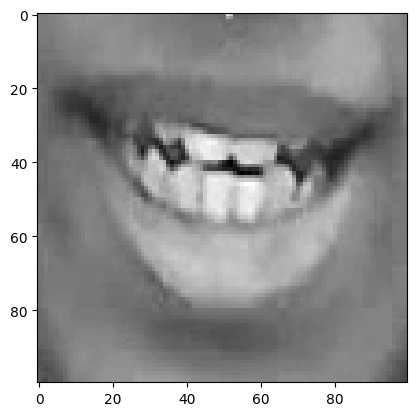

(700, 10, 100, 100)


In [52]:
x_train = np.array(x_train)
one =x_train[0][4]
print(one.shape)
plt.imshow(one,cmap='gray')
plt.show()
print(x_train.shape)


In [53]:
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

print("X Training shape: ",x_train.shape)
print("X Test shape: ",x_test.shape)
print("X Validation shape: ",x_val.shape)
print("Y Training shape: ",y_train.shape)
print("Y Test shape: ",y_test.shape)
print("Y Validation shape: ",y_val.shape)

X Training shape:  (700, 10, 100, 100)
X Test shape:  (100, 10, 100, 100)
X Validation shape:  (200, 10, 100, 100)
Y Training shape:  (700,)
Y Test shape:  (100,)
Y Validation shape:  (200,)


In [54]:
x =np.isnan(x_train).sum()
print(x)

0


In [55]:
def normalize_it(X):
    v_min = X.min(axis=(2, 3), keepdims=True)
    v_max = X.max(axis=(2, 3), keepdims=True)
    #print(v_min)
    #print('Max: ',v_max)
    X = (X - v_min)/(v_max - v_min)
    X = np.nan_to_num(X)
    return X

In [57]:
def clean(x_train,x_val,x_test,y_train,y_val,y_test):
    print()
    print("Normalizing data...")
    t1 = time.time()
    x_train = normalize_it(x_train)
    #print(X_train)
    x_val = normalize_it(x_val)
    x_test = normalize_it(x_test)
    t2 =time.time()
    print()
    print(f"Time taken to normalize images: {t2 - t1} secs")

    print()
    print("One hot encoding labels...")
    t3 = time.time()
    y_train = np_utils.to_categorical(y_train, 10)
    y_test = np_utils.to_categorical(y_test, 10)
    y_val = np_utils.to_categorical(y_val, 10)
    t4 = time.time()
    print()
    print(f"Time taken to convert labels to categorical: {t4 - t3} secs")

    print()
    print("Shuffling data...")
    t5 = time.time()
    X_train, y_train = shuffle(x_train, y_train, random_state=0)
    X_test, y_test = shuffle(x_test, y_test, random_state=0)
    X_val, y_val = shuffle(x_val, y_val, random_state=0)
    t6 = time.time()
    print()
    print(f"Time taken to shuffle data: {t6 - t5} secs")
    
    print()
    print("Reshaping data...")
    t7 = time.time()
    x_train = np.expand_dims(x_train, axis=4)
    x_val = np.expand_dims(x_val, axis=4)
    x_test = np.expand_dims(x_test, axis=4)
    t8 = time.time()
    print()
    print(f"Time taken to reshape data: {t8 - t7} secs")
    print()

    print(x_train.shape)
    print(x_val.shape)
    print(x_test.shape)
    return x_train, x_val, x_test, y_train, y_val, y_test

In [58]:
x_train, x_val, x_test, y_train, y_val, y_test = clean(x_train,x_val,x_test,y_train,y_val,y_test)


Normalizing data...

Time taken to normalize images: 2.6911184787750244 secs

One hot encoding labels...

Time taken to convert labels to categorical: 0.0 secs

Shuffling data...

Time taken to shuffle data: 0.3084425926208496 secs

Reshaping data...

Time taken to reshape data: 0.0 secs

(700, 10, 100, 100, 1)
(200, 10, 100, 100, 1)
(100, 10, 100, 100, 1)


In [60]:
'''

MODEL WITH 100% TRAINING ACCURACY

'''

model = Sequential()

model.add(Conv3D(32, (3, 3, 3), strides = 1, input_shape=(10, 100, 100, 1), activation='relu', padding='valid'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add(Conv3D(64, (3, 3, 3), activation='relu', strides=1))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))


shape = (1,10,10,128)
model.add((Flatten()))
model.add(Dense(10, activation='softmax'))
model.compile(loss = 'categorical_crossentropy',optimizer = 'Adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 8, 98, 98, 32)     896       
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 4, 49, 49, 32)    0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 2, 47, 47, 64)     55360     
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 1, 23, 23, 64)    0         
 3D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 33856)             0         
                                                                 
 dense_1 (Dense)             (None, 10)               

In [61]:
t1 = time.time()
#history = model.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks = [earlyStopping], epochs=45)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=35)
t2 = time.time()
print()
print(f"Training time : {(t2 - t1)/60} mins.")

Epoch 1/35
22/22 [==============================] - 66s 3s/step - loss: 2.3340 - accuracy: 0.0914 - val_loss: 2.3028 - val_accuracy: 0.0900
Epoch 2/35
22/22 [==============================] - 65s 3s/step - loss: 2.3026 - accuracy: 0.0929 - val_loss: 2.3057 - val_accuracy: 0.1000
Epoch 3/35
22/22 [==============================] - 65s 3s/step - loss: 2.3022 - accuracy: 0.1043 - val_loss: 2.3060 - val_accuracy: 0.1000
Epoch 4/35
22/22 [==============================] - 65s 3s/step - loss: 2.2989 - accuracy: 0.1186 - val_loss: 2.3082 - val_accuracy: 0.1300
Epoch 5/35
22/22 [==============================] - 65s 3s/step - loss: 2.2911 - accuracy: 0.1229 - val_loss: 2.3101 - val_accuracy: 0.0950
Epoch 6/35
22/22 [==============================] - 65s 3s/step - loss: 2.2848 - accuracy: 0.1457 - val_loss: 2.3136 - val_accuracy: 0.0950
Epoch 7/35
22/22 [==============================] - 65s 3s/step - loss: 2.2812 - accuracy: 0.1557 - val_loss: 2.3648 - val_accuracy: 0.1000
Epoch 8/35
22/22 [==

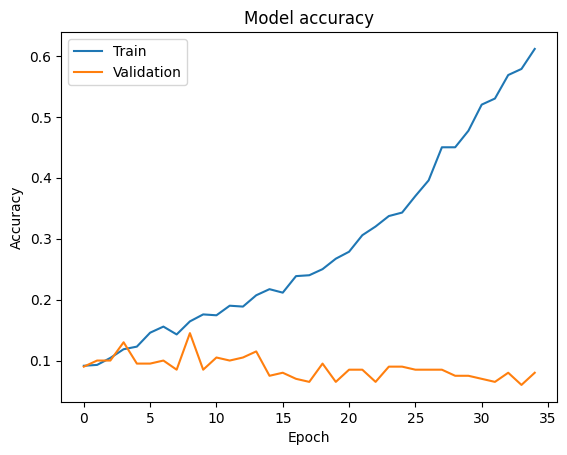

In [62]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

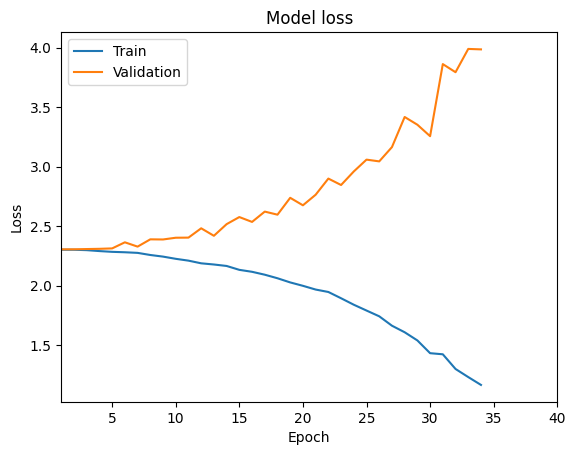

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(1, 40)
# plt.ylim(0, 3)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [64]:
ypred = model.predict(x_test)
predicted_words = [words[i] for i in np.argmax(ypred, axis=1)]
actual_words = [words[i] for i in np.argmax(y_test,axis=1)]

4/4 [==============================] - 1s 161ms/step


In [65]:
correct = 0
for p, a in zip(predicted_words, actual_words):
    if p == a:
        correct += 1
    print(f"Predicted : {p} \t Actual : {a}")

accuracy = correct/len(actual_words)
print()
print()
print(f"Accuracy = {accuracy*100}% on testing data")

Predicted : Start 	 Actual : Connection
Predicted : Next 	 Actual : Hello
Predicted : Start 	 Actual : Begin
Predicted : Choose 	 Actual : Previous
Predicted : Choose 	 Actual : Stop
Predicted : Stop 	 Actual : Web
Predicted : Choose 	 Actual : Choose
Predicted : Stop 	 Actual : Stop
Predicted : Start 	 Actual : Previous
Predicted : Start 	 Actual : Web
Predicted : Web 	 Actual : Previous
Predicted : Hello 	 Actual : Web
Predicted : Choose 	 Actual : Stop
Predicted : Web 	 Actual : Choose
Predicted : Begin 	 Actual : Begin
Predicted : Begin 	 Actual : Navigation
Predicted : Hello 	 Actual : Connection
Predicted : Hello 	 Actual : Connection
Predicted : Hello 	 Actual : Navigation
Predicted : Web 	 Actual : Begin
Predicted : Begin 	 Actual : Next
Predicted : Web 	 Actual : Start
Predicted : Hello 	 Actual : Begin
Predicted : Hello 	 Actual : Stop
Predicted : Web 	 Actual : Next
Predicted : Next 	 Actual : Next
Predicted : Choose 	 Actual : Begin
Predicted : Begin 	 Actual : Web
Predicte

In [66]:
model.save("self_training_model1.h5")